# Table of Contents
* [Load mapped reads and generate a matrix](#Load-mapped-reads-and-generate-a-matrix)
	* [Map restriction fragments](#Map-restriction-fragments)
	* [Extract uniquely mapped reads](#Extract-uniquely-mapped-reads)
		* [Iterative mapping](#Iterative-mapping)
		* [Fragment-based mapping](#Fragment-based-mapping)
	* [Keep only pair of reads where both are mapped uniquely](#Keep-only-pair-of-reads-where-both-are-mapped-uniquely)
* [Quality check of the Hi-C experiment](#Quality-check-of-the-Hi-C-experiment)
	* [Number of interactions versus genomic distance](#Number-of-interactions-versus-genomic-distance)
	* [Genomic coverage](#Genomic-coverage)
	* [First Hi-C map](#First-Hi-C-map)
	* [Insert size](#Insert-size)


# Load mapped reads and generate a matrix

We read now each read in the map files. We want reads that are uniquely mapped and from each of them we store:
  - the strand
  - the position, or cut-site (real position + read length, in case it's reverse strand)
  - the chromosome
  - the sequence
  - the **restriction enzyme fragment** on which it stands
  
This information will be used to filter the reads and, finally, to construct the interaction matrices.

## Map restriction fragments

First we need to load the _Homo sapiens_ genomic sequence:

In [52]:
from pytadbit.parsers.genome_parser import parse_fasta
from matplotlib import pyplot as plt
import numpy as np

In [20]:
genome_seq = parse_fasta('/media/storage/db/reference_genome/Homo_sapiens/hg38/hg38.fa')

Parsing chr1
Parsing chr2
Parsing chr3
Parsing chr4
Parsing chr5
Parsing chr6
Parsing chr7
Parsing chr8
Parsing chr9
Parsing chr10
Parsing chr11
Parsing chr12
Parsing chr13
Parsing chr14
Parsing chr15
Parsing chr16
Parsing chr17
Parsing chr18
Parsing chr19
Parsing chr20
Parsing chr21
Parsing chr22
Parsing chrX
Parsing chrY


We have loaded the full human genome:

In [3]:
plt.bar(range(len(genome_seq)), [len(genome_seq[c]) for c in genome_seq], 
        color='k', alpha=0.7)
_ = plt.xticks([v + 0.5 for v in range(len(genome_seq))], genome_seq.keys(), rotation=90)
plt.grid()

Then, we search for restriction enzyme sites in this sequence.

In [4]:
from pytadbit.mapping.restriction_enzymes import map_re_sites

frags_HindIII = map_re_sites('HindIII', genome_seq, verbose=True)
frags_MboI    = map_re_sites('MboI'   , genome_seq, verbose=True)

Found 860365 RE sites
Found 7199434 RE sites


In [5]:
c0 = frags_HindIII.keys()[0]
v0 = 0
dists_HindIII = []
for c1, v1 in [(c, v) for c in frags_HindIII for p in frags_HindIII[c] 
               for v in frags_HindIII[c][p]]:
    if c1 == c0:
        diff = abs(v1 - v0)
        if diff < 30000:  # larger fragments are probably poorly assembled regions
            dists_HindIII.append(diff)
    v0 = v1
c0 = frags_MboI.keys()[0]
v0 = 0
dists_MboI = []
for c1, v1 in [(c, v) for c in frags_MboI for p in frags_MboI[c] 
               for v in frags_MboI[c][p]]:
    if c1 == c0:
        diff = abs(v1 - v0)
        if diff < 30000:  # larger fragments are probably poorly assembled regions
            dists_MboI.append(diff)
    v0 = v1

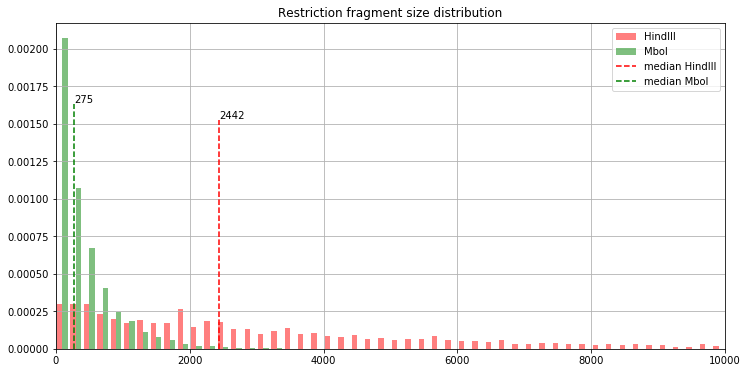

In [12]:
plt.figure(figsize=(12, 6))
_ = plt.hist([dists_HindIII, dists_MboI], bins=50, color=['red', 'green'], 
             alpha=0.5, label=['HindIII', 'MboI'], normed=True, range=(0, 10000))
y0, y1 = plt.ylim()
plt.vlines(np.median(dists_HindIII), y0, y1 * 0.7, color='red', linestyle='--',
          label='median HindIII')
plt.vlines(np.median(dists_MboI)   , y0, y1 * 0.75, color='green', linestyle='--',
          label='median MboI')
plt.text(np.median(dists_HindIII), y1 * 0.7, '%.0f' % np.median(dists_HindIII), va='bottom', 
         ha='left')
plt.text(np.median(dists_MboI)   , y1 * 0.75,'%.0f' % np.median(dists_MboI)   , va='bottom', 
         ha='left')
plt.title('Restriction fragment size distribution')
plt.legend()
plt.xlim(0, 10000)
plt.grid()

## Extract uniquely mapped reads

In [84]:
# replicate and enzyme useds
r_enz = 'MboI'

### Iterative mapping

In case we haven't stored the location of each of the reads we could load them like this:

In [46]:
maps1 = [('results/iterativ/{0}/01_mapping/mapped_{0}_r1/'
          'K562_{0}_1_full_1-{1}.map').format(r_enz, i) 
         for i in range(25, 80, 5)]

maps2 = [('results/iterativ/{0}/01_mapping/mapped_{0}_r2/'
          'K562_{0}_2_full_1-{1}.map').format(r_enz, i) 
         for i in range(25, 80, 5)]

Load all reads, check if they are uniquely mapped. Result is stored in two separate file tab-separated files that will contain the essential information of each read

In [47]:
from pytadbit.parsers.map_parser import parse_map

In [48]:
! mkdir -p results/iterativ/$r_enz/02_parsing

In [49]:
parse_map(maps1, maps2,
          'results/iterativ/{0}/02_parsing/reads1_{0}.tsv'.format(r_enz),
          'results/iterativ/{0}/02_parsing/reads2_{0}.tsv'.format(r_enz),
          genome_seq=genome_seq, re_name=r_enz verbose=True)

Searching and mapping RE sites to the reference genome
Found 860365 RE sites
Loading read1
loading file: results/iterativ/HindIII/01_mapping/mapped_HindIII_r1/K562_HindIII_1_full_1-25.map
loading file: results/iterativ/HindIII/01_mapping/mapped_HindIII_r1/K562_HindIII_1_full_1-30.map
loading file: results/iterativ/HindIII/01_mapping/mapped_HindIII_r1/K562_HindIII_1_full_1-35.map
loading file: results/iterativ/HindIII/01_mapping/mapped_HindIII_r1/K562_HindIII_1_full_1-40.map
loading file: results/iterativ/HindIII/01_mapping/mapped_HindIII_r1/K562_HindIII_1_full_1-45.map
loading file: results/iterativ/HindIII/01_mapping/mapped_HindIII_r1/K562_HindIII_1_full_1-50.map
loading file: results/iterativ/HindIII/01_mapping/mapped_HindIII_r1/K562_HindIII_1_full_1-55.map
loading file: results/iterativ/HindIII/01_mapping/mapped_HindIII_r1/K562_HindIII_1_full_1-60.map
loading file: results/iterativ/HindIII/01_mapping/mapped_HindIII_r1/K562_HindIII_1_full_1-65.map
loading file: results/iterativ/HindI

({0: {1: 7668768,
   2: 294657,
   3: 194330,
   4: 138392,
   5: 101157,
   6: 97959,
   7: 63897,
   8: 47601,
   9: 36706,
   10: 29015,
   11: 29522},
  1: {1: 7567512,
   2: 313813,
   3: 206899,
   4: 142617,
   5: 104512,
   6: 110867,
   7: 66378,
   8: 50196,
   9: 38320,
   10: 29989,
   11: 36913}},
 {0: 0, 1: 0})

In [50]:
from pytadbit.mapping.analyze import plot_iterative_mapping

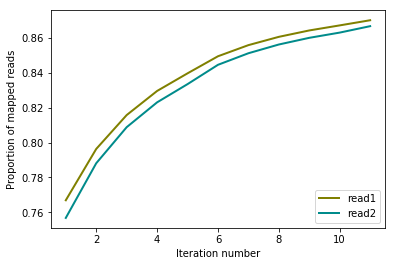

In [51]:
total_reads = 10000000

lengths = plot_iterative_mapping(
    'results/iterativ/{0}/02_parsing/reads1_{0}.tsv'.format(r_enz), 
    'results/iterativ/{0}/02_parsing/reads2_{0}.tsv'.format(r_enz), 
    total_reads)

### Fragment-based mapping

In [54]:
! mkdir -p results/fragment/$r_enz/02_parsing

In [85]:
maps1 = [('results/fragment/{0}/01_mapping/map{0}_r1/'
          'K562_{0}_1_full_1-end.map').format(r_enz),
         ('results/fragment/{0}/01_mapping/map{0}_r1/'
          'K562_{0}_1_frag_1-end.map').format(r_enz)]

maps2 = [('results/fragment/{0}/01_mapping/map{0}_r2/'
          'K562_{0}_2_full_1-end.map').format(r_enz),
         ('results/fragment/{0}/01_mapping/map{0}_r2/'
          'K562_{0}_2_frag_1-end.map').format(r_enz)]

In [86]:
maps1

['results/fragment/MboI/01_mapping/mapMboI_r1/K562_MboI_1_full_1-end.map',
 'results/fragment/MboI/01_mapping/mapMboI_r1/K562_MboI_1_frag_1-end.map']

In [87]:
parse_map(maps1, maps2,
          'results/{0}/02_parsing/reads1_{0}.tsv'.format(r_enz), 
          'results/{0}/02_parsing/reads2_{0}.tsv'.format(r_enz), 
          genome_seq=genome_seq, re_name=r_enz, verbose=True)

Searching and mapping RE sites to the reference genome
Found 7199434 RE sites
Loading read1
loading file: results/fragment/MboI/01_mapping/mapMboI_r1/K562_MboI_1_full_1-end.map
loading file: results/fragment/MboI/01_mapping/mapMboI_r1/K562_MboI_1_frag_1-end.map
Merge sort...........
Getting Multiple contacts
Loading read2
loading file: results/fragment/MboI/01_mapping/mapMboI_r2/K562_MboI_2_full_1-end.map
loading file: results/fragment/MboI/01_mapping/mapMboI_r2/K562_MboI_2_frag_1-end.map
Merge sort..........
Getting Multiple contacts


({0: {1: 5297715, 2: 5112708}, 1: {1: 5081286, 2: 4736008}},
 {0: 1509291, 1: 1377121})

In [92]:
reads1 = 'results/{0}/02_parsing/reads1_{0}.tsv'.format(r_enz)
reads2 = 'results/{0}/02_parsing/reads2_{0}.tsv'.format(r_enz)

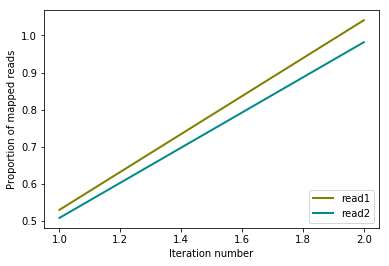

In [69]:
total_reads = 10000000

lengths = plot_iterative_mapping(reads1, reads2, total_reads)

_From now on we are going to focus only on the results of the fragment based mapping_

## Keep only pair of reads where both are mapped uniquely

In [88]:
from pytadbit.mapping import get_intersection

In [89]:
! mkdir -p results/$r_enz/03_filtering

In [90]:
reads = 'results/{0}/03_filtering/reads12_{0}.tsv'.format(r_enz)

In [93]:
get_intersection(reads1, reads2, reads, verbose=True)

Getting intersection of reads 1 and reads 2:
 
  .........
Found 7885638 pair of reads mapping uniquely
Sorting each temporary file by genomic coordinate
    1025/1025 sorted files
Removing temporary files...


(7885638, {2: 1280575, 3: 52171, 4: 4})

# Quality check of the Hi-C experiment

## Number of interactions versus genomic distance

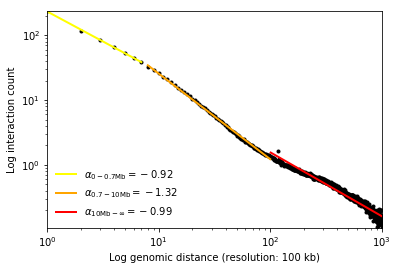

((-0.92462928472719363, 5.4509551589781413, -0.99903492971358521),
 (-1.3206691978372496, 6.2859200683608734, -0.99888497682950872),
 (-0.98603864599535584, 4.9897535688580685, -0.98356051074989215))

In [74]:
from pytadbit.mapping.analyze import plot_distance_vs_interactions

plot_distance_vs_interactions(reads, resolution=100000, max_diff=1000, show=True)

According to the fractal globule model <a name="ref-1"/>[(Mirny, 2011)](#cite-Mirny2011) the slope between 700 kb and 10 Mb should be around -1 in log scale

## Genomic coverage

In [75]:
from pytadbit.mapping.analyze import plot_genomic_distribution

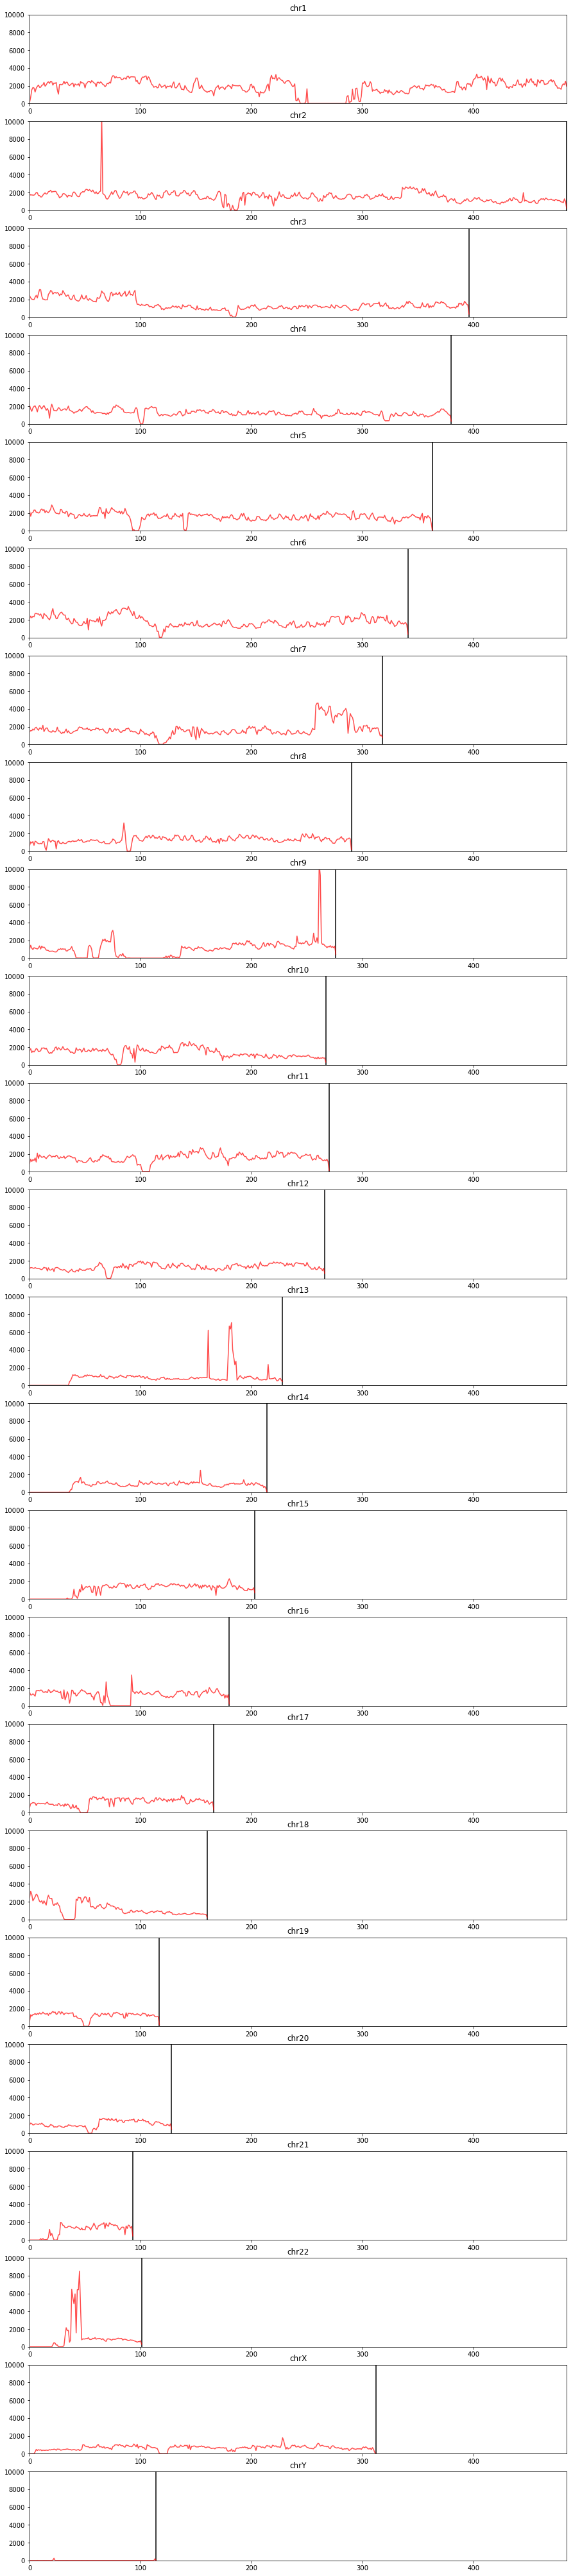

In [76]:
plot_genomic_distribution(reads, resolution=500000, ylim=(0, 10000), show=True)

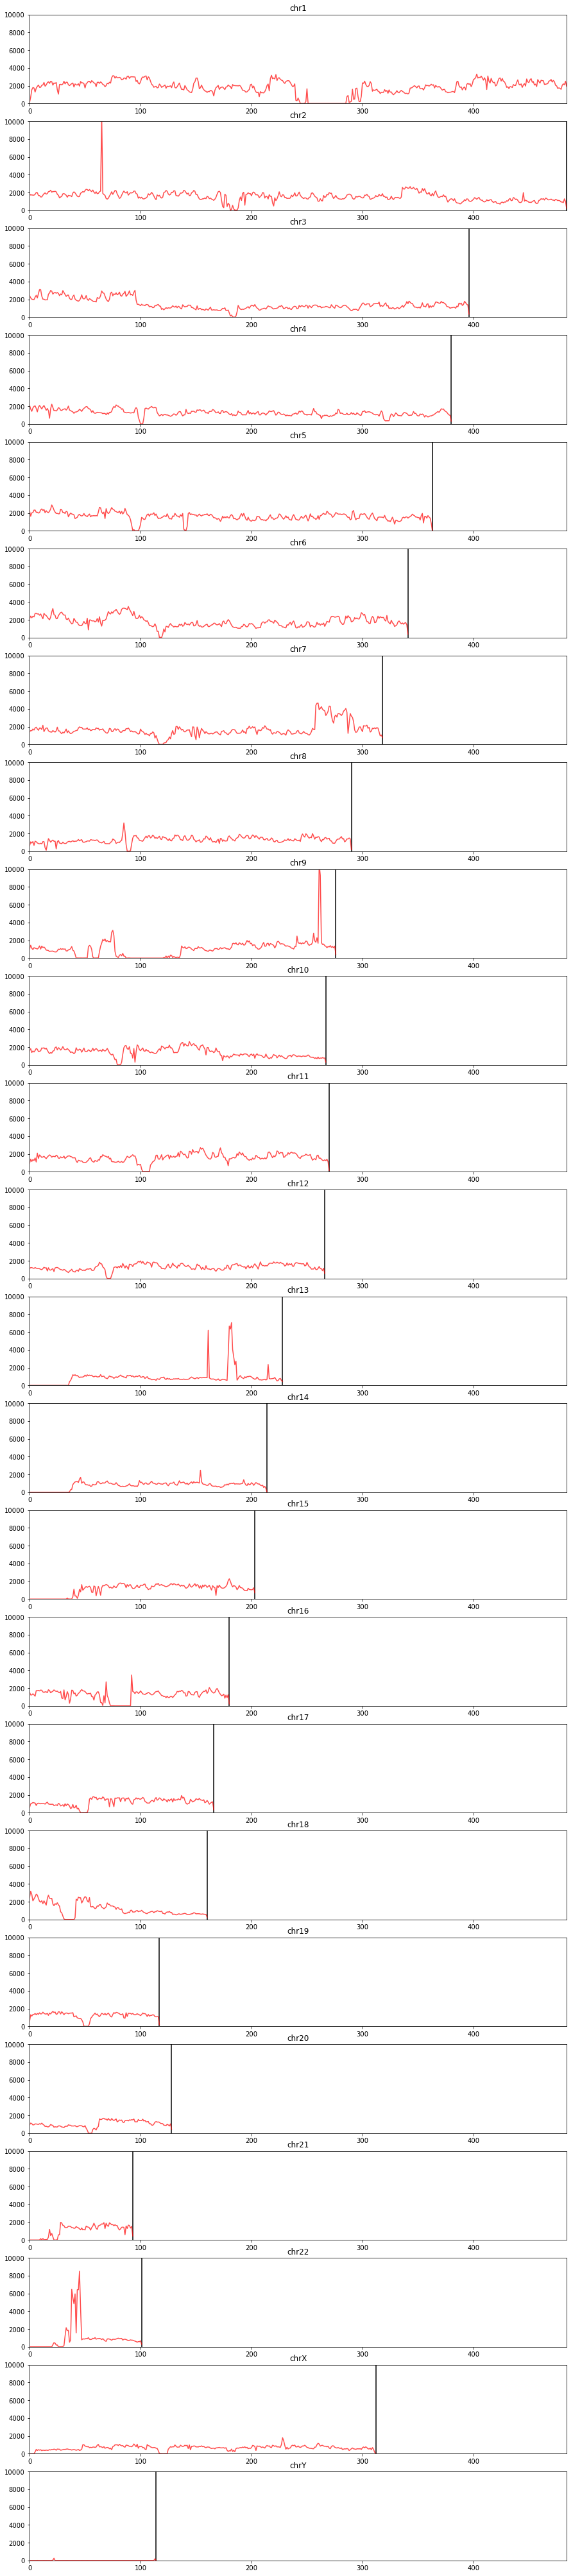

In [76]:
plot_genomic_distribution(reads, resolution=500000, ylim=(0, 10000), show=True)

We are working with a cell line with a very aberrant karyotype (https://commons.wikimedia.org/wiki/File:Karyotype_of_the_T47D_breast_cancer_cell_line.svg).

## First Hi-C map

In [77]:
from pytadbit.mapping.analyze import hic_map

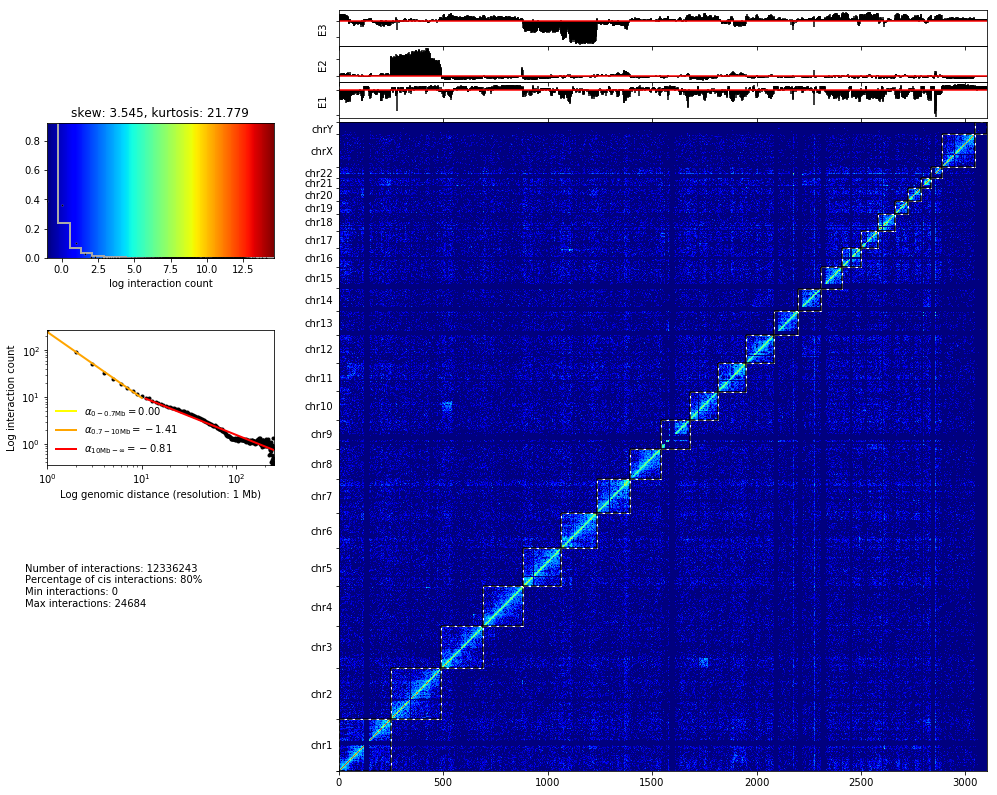

In [78]:
hic_map(reads, resolution=1000000, show=True)

## Insert size

From the reads that are mapped in a single fragment we can infer the average insert size:

In [94]:
from pytadbit.mapping.analyze import insert_sizes

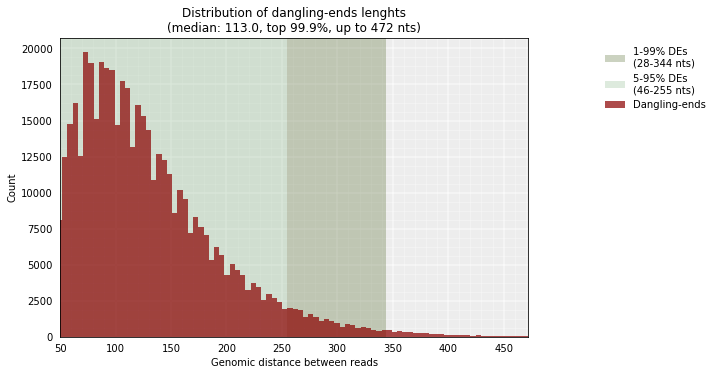

[113.0, 472.0]

In [95]:
insert_sizes(reads, show=True, nreads=1000000)

The median size of the sequenced DNA fragments is thus 113 nt.

<!--bibtex
@article{Mirny2011,
abstract = {The fractal globule is a compact polymer state that emerges during polymer condensation as a result of topological constraints which prevent one region of the chain from passing across another one. This long-lived intermediate state was introduced in 1988 (Grosberg et al. 1988) and has not been observed in experiments or simulations until recently (Lieberman-Aiden et al. 2009). Recent characterization of human chromatin using a novel chromosome conformational capture technique brought the fractal globule into the spotlight as a structural model of human chromosome on the scale of up to 10 Mb (Lieberman-Aiden et al. 2009). Here, we present the concept of the fractal globule, comparing it to other states of a polymer and focusing on its properties relevant for the biophysics of chromatin. We then discuss properties of the fractal globule that make it an attractive model for chromatin organization inside a cell. Next, we connect the fractal globule to recent studies that emphasize topological constraints as a primary factor driving formation of chromosomal territories. We discuss how theoretical predictions, made on the basis of the fractal globule model, can be tested experimentally. Finally, we discuss whether fractal globule architecture can be relevant for chromatin packing in other organisms such as yeast and bacteria.},
author = {Mirny, Leonid a},
doi = {10.1007/s10577-010-9177-0},
file = {:home/fransua/.local/share/data/Mendeley Ltd./Mendeley Desktop/Downloaded/Mirny - 2011 - The fractal globule as a model of chromatin architecture in the cell.pdf:pdf},
issn = {1573-6849},
journal = {Chromosome research : an international journal on the molecular, supramolecular and evolutionary aspects of chromosome biology},
keywords = {Biophysics,Chromatin,Chromatin: ultrastructure,Chromosomes, Human,Fractals,Humans,Models, Molecular,Protein Conformation,Protein Folding},
mendeley-groups = {Research articles,projects/FEBS{\_}review/modeling{\_}perspectives},
month = {jan},
number = {1},
pages = {37--51},
pmid = {21274616},
title = {{The fractal globule as a model of chromatin architecture in the cell.}},
url = {http://www.pubmedcentral.nih.gov/articlerender.fcgi?artid=3040307{\&}tool=pmcentrez{\&}rendertype=abstract},
volume = {19},
year = {2011}
}
-->

# References

<a name="cite-Mirny2011"/><sup>[^](#ref-1) </sup>Mirny, Leonid a. 2011. _The fractal globule as a model of chromatin architecture in the cell._. [URL](http://www.pubmedcentral.nih.gov/articlerender.fcgi?artid=3040307{\&}tool=pmcentrez{\&}rendertype=abstract)

